In [1]:
import pandas as pd 
import yfinance as yf
from datetime import date , timedelta

In [2]:
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

# AMD, NVIDIA, QUALCOMM, ORACLE
tickers = ['AMD','NVDA','QCOM','ORCL']

data = yf.download(tickers , start=start_date, end=end_date, progress=False)

data = data.reset_index()

data_melted = data.melt(id_vars=['Date'], var_name=['Attribute', 'Tickers'])

data_pivoted =data_melted.pivot_table(index=['Date', 'Tickers'], columns='Attribute', values='value', aggfunc='first')

stock_data = data_pivoted.reset_index()

print(stock_data.head())

Attribute       Date Tickers   Adj Close       Close        High         Low  \
0         2023-07-14     AMD  115.940002  115.940002  122.120003  115.250000   
1         2023-07-14    NVDA   45.455391   45.469002   48.088001   45.060001   
2         2023-07-14    ORCL  117.663452  119.269997  119.970001  117.680000   
3         2023-07-14    QCOM  119.826965  122.559998  123.180000  121.129997   
4         2023-07-17     AMD  118.320000  118.320000  118.839996  112.730003   

Attribute        Open       Volume  
0          116.169998   91847300.0  
1           46.583000  772075000.0  
2          118.180000    7720900.0  
3          123.000000    7889800.0  
4          115.949997   68593300.0  


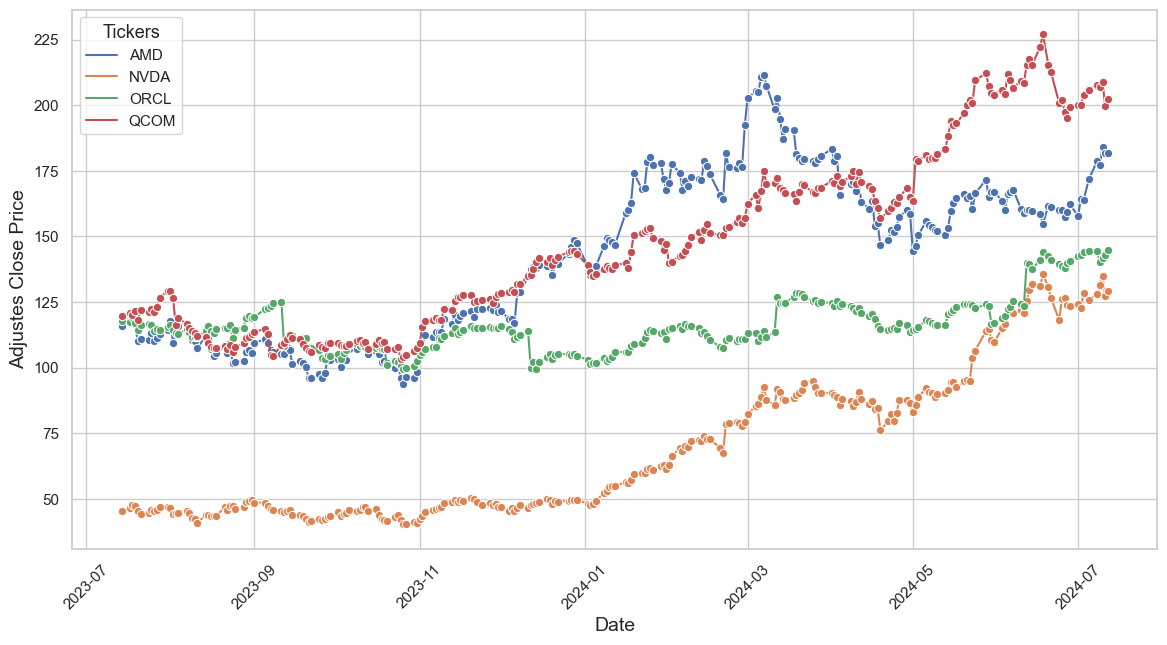

In [3]:
import matplotlib.pyplot as plt 
import seaborn as sns 

stock_data['Date'] = pd.to_datetime(stock_data['Date'])

stock_data.set_index('Date',inplace=True)
stock_data.reset_index(inplace=True)
plt.figure(figsize=(14,7))
sns.set(style='whitegrid')

sns.lineplot(data=stock_data, x='Date', y='Adj Close', hue='Tickers', marker='o')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjustes Close Price', fontsize=14)
plt.legend(title='Tickers', title_fontsize='13', fontsize='11')
plt.grid(True)

plt.xticks(rotation=45)

plt.show()

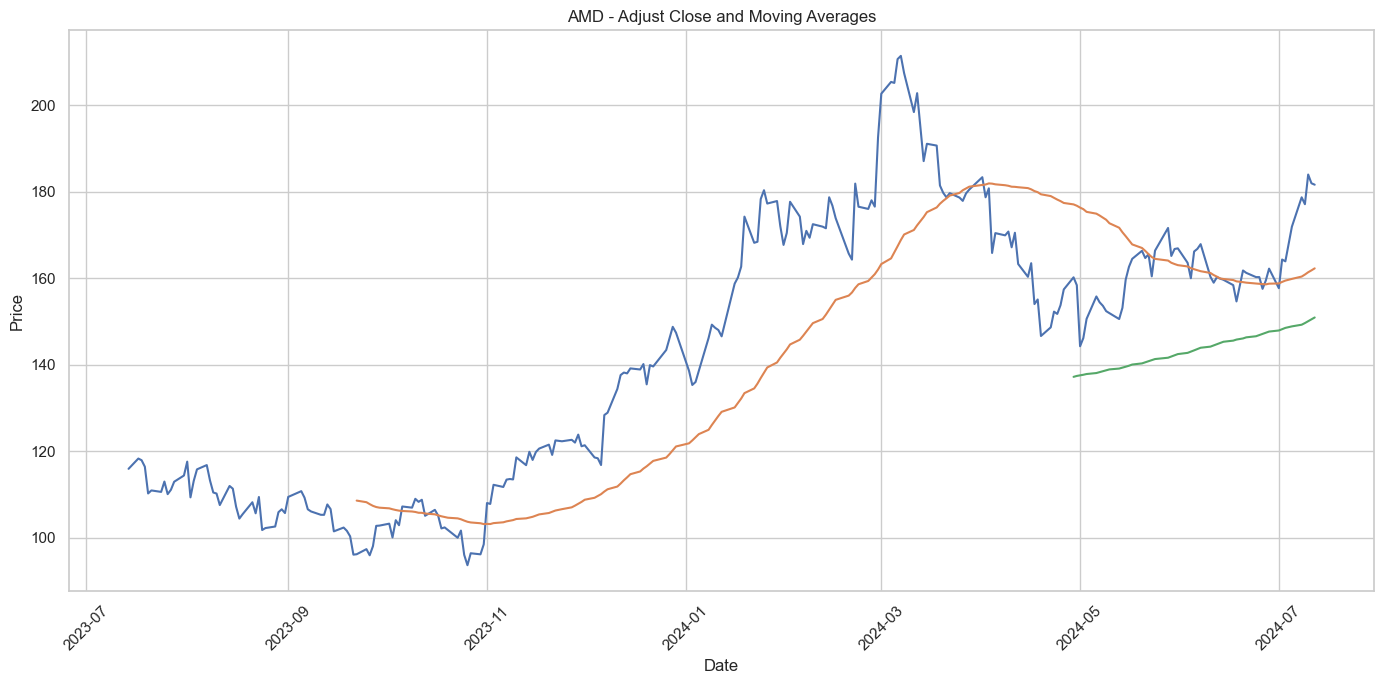

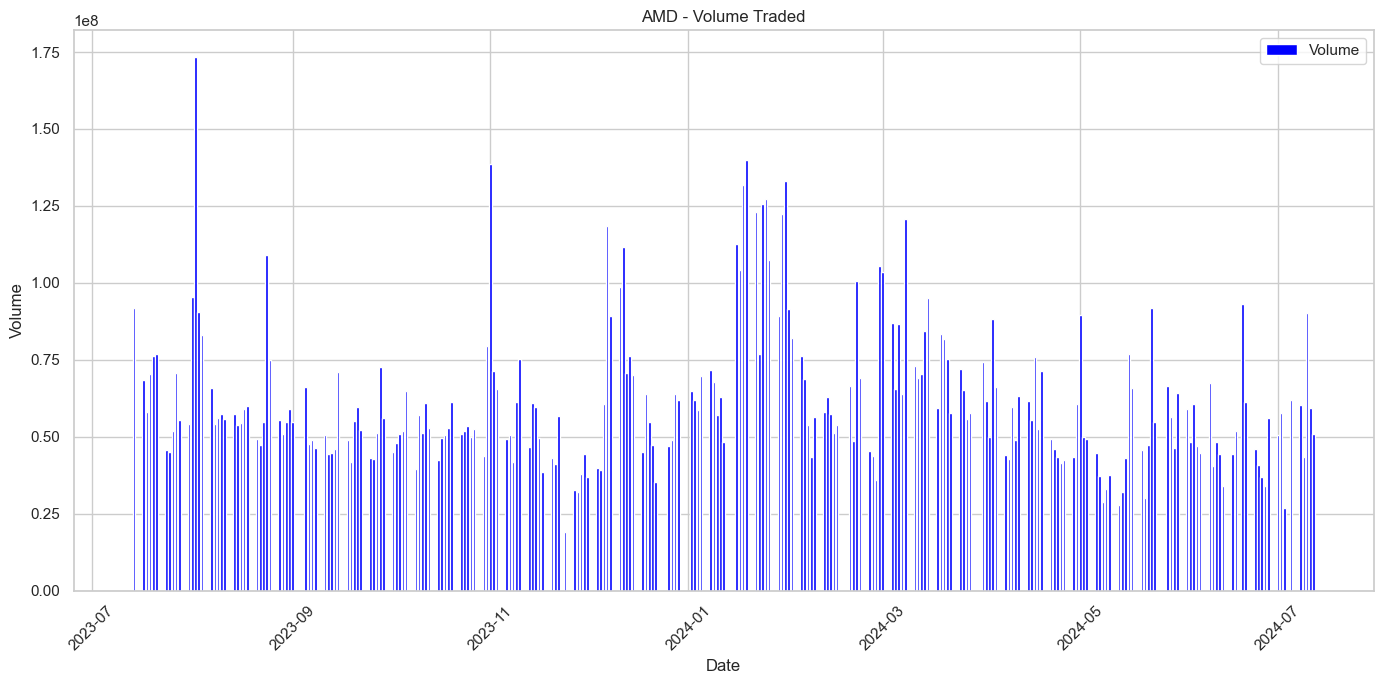

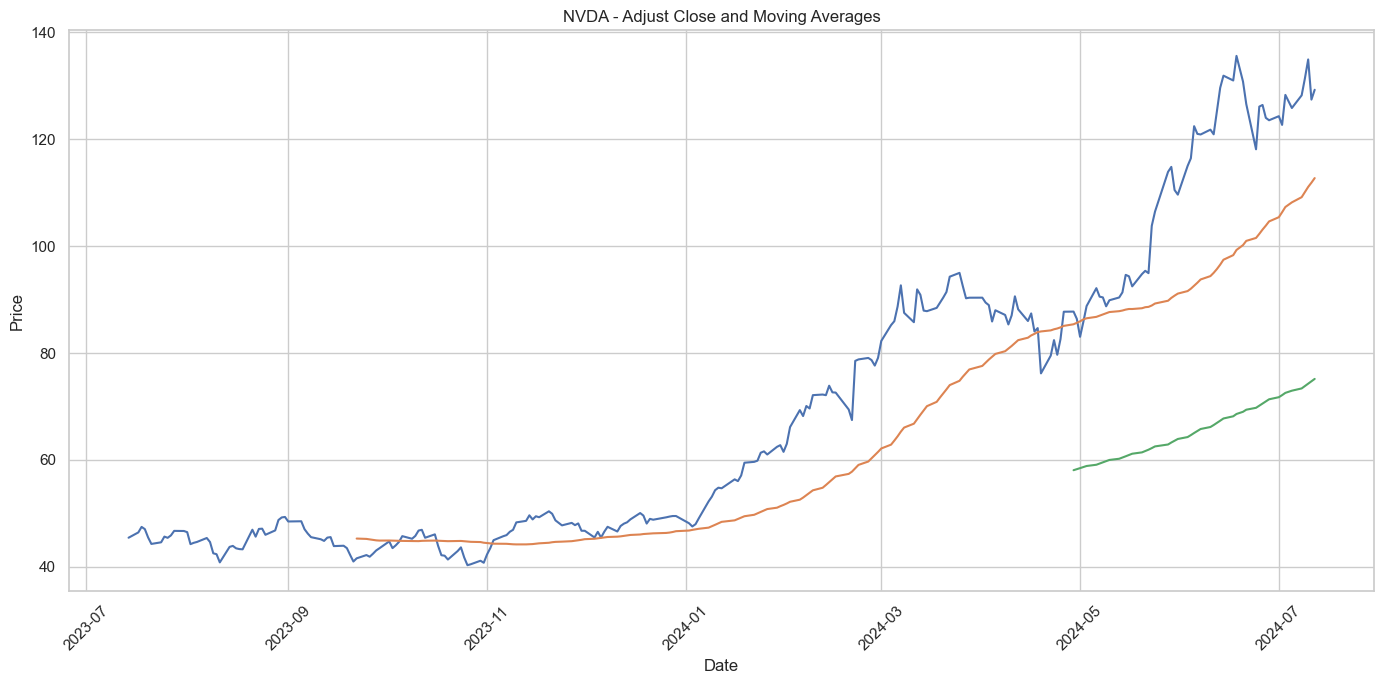

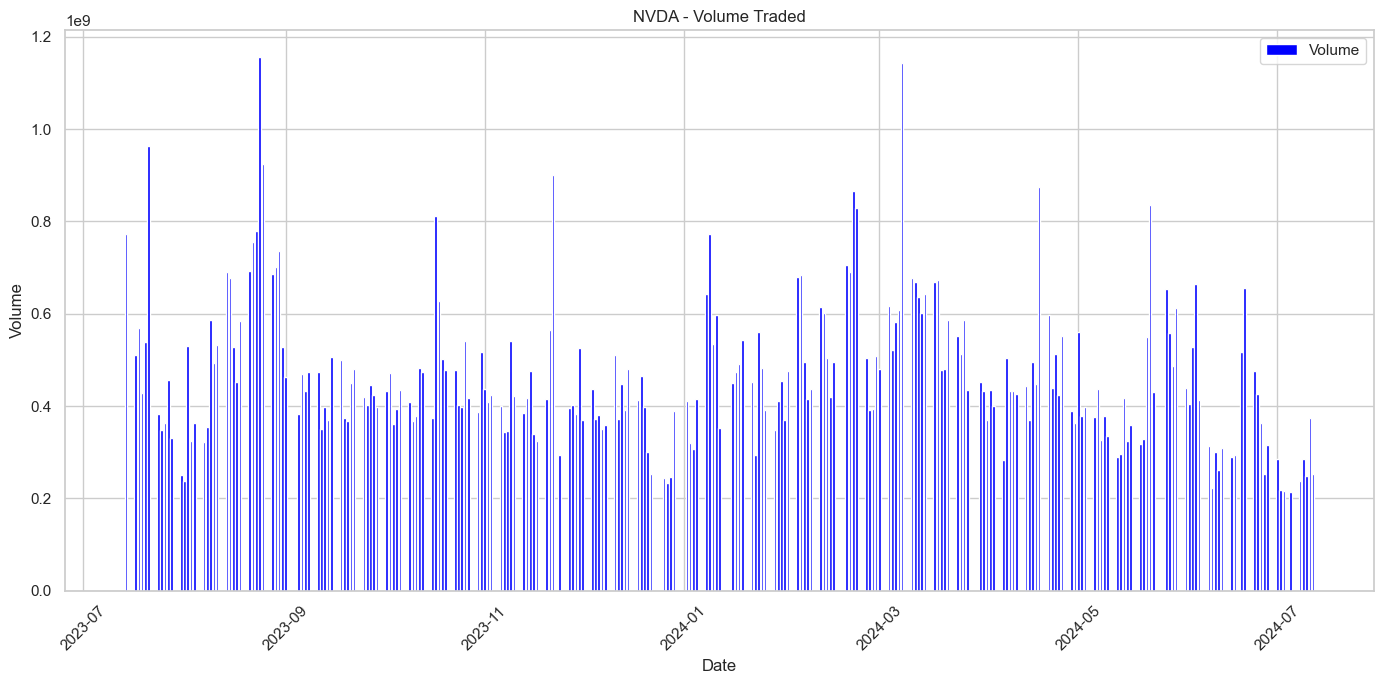

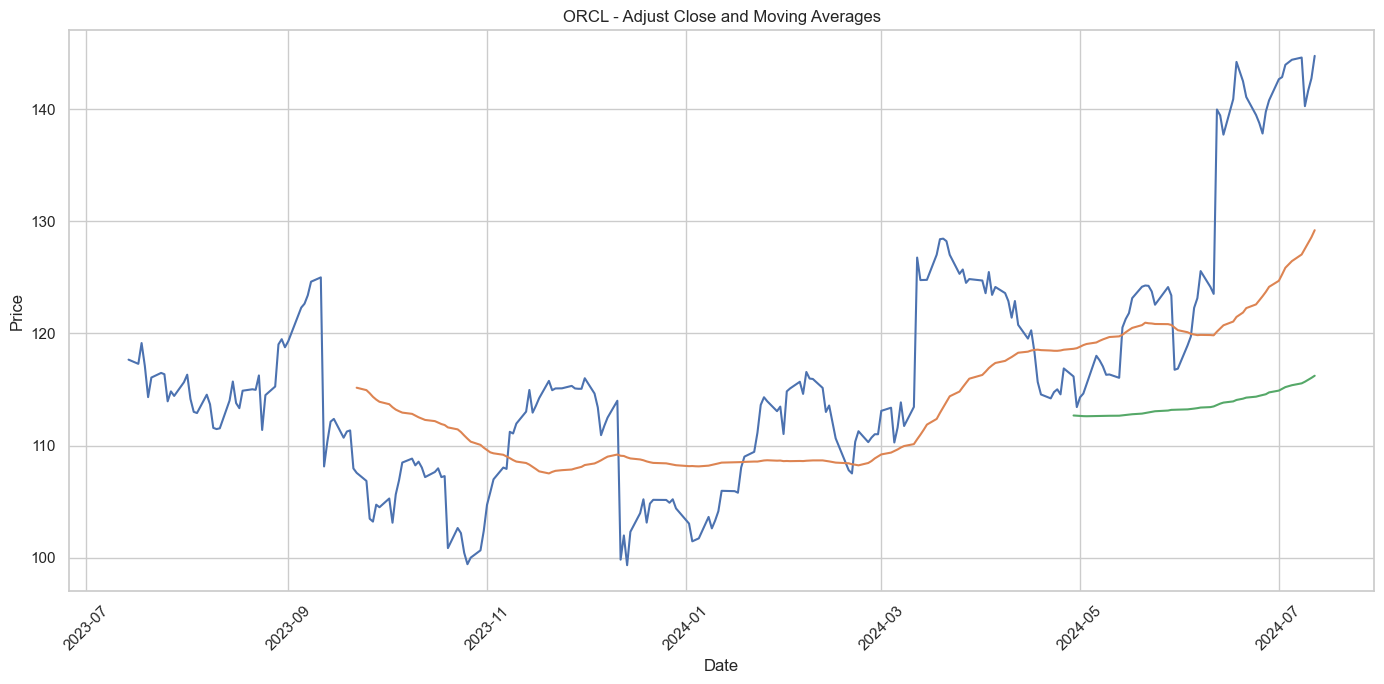

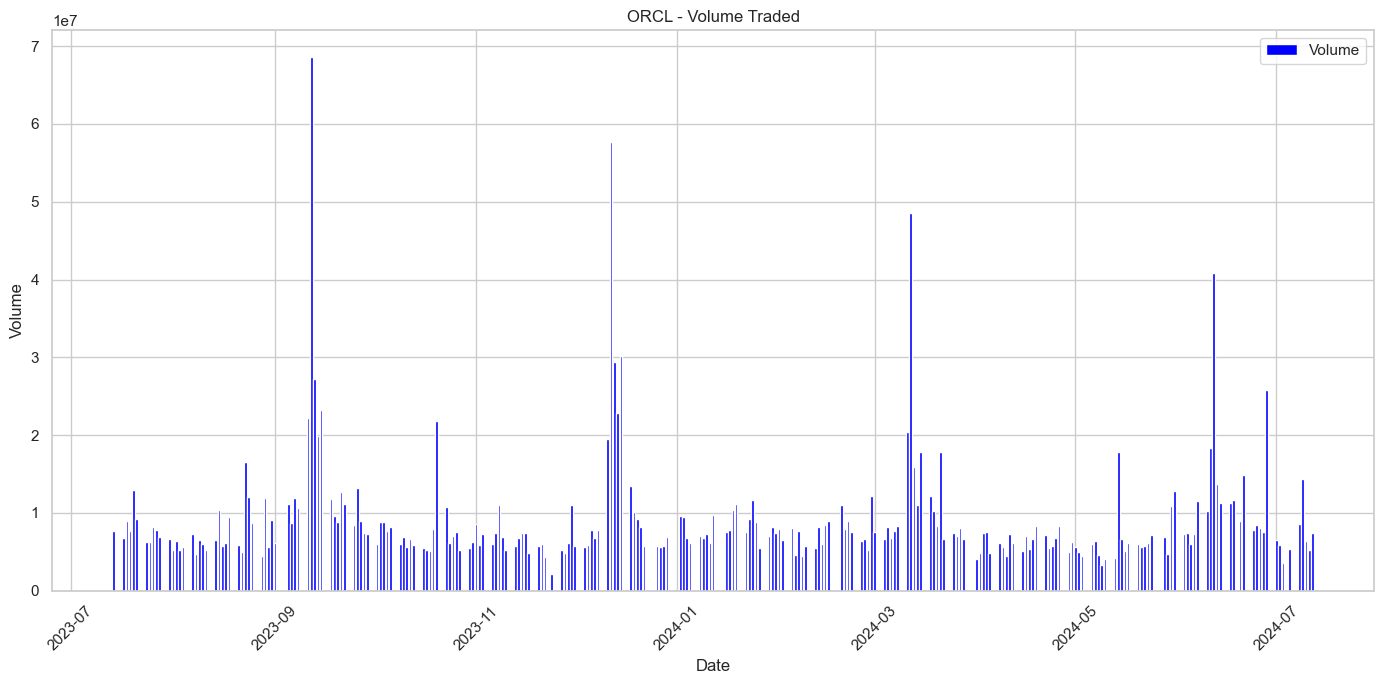

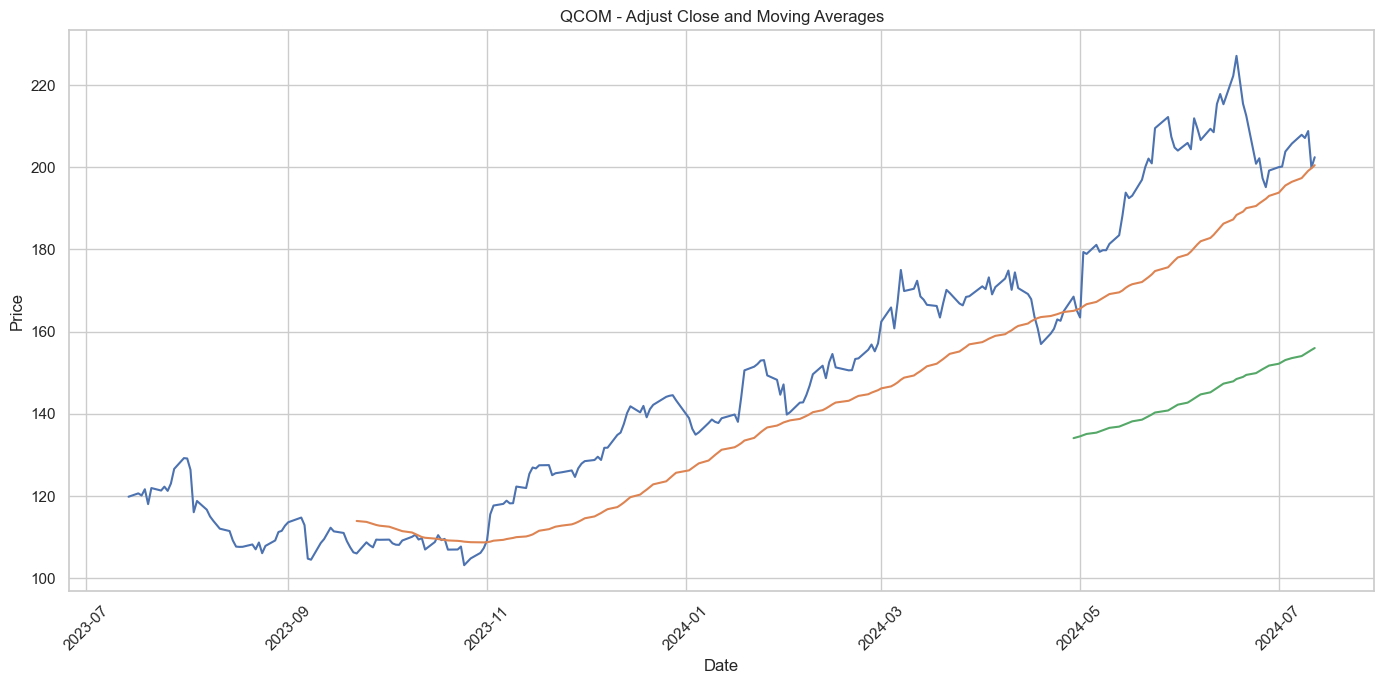

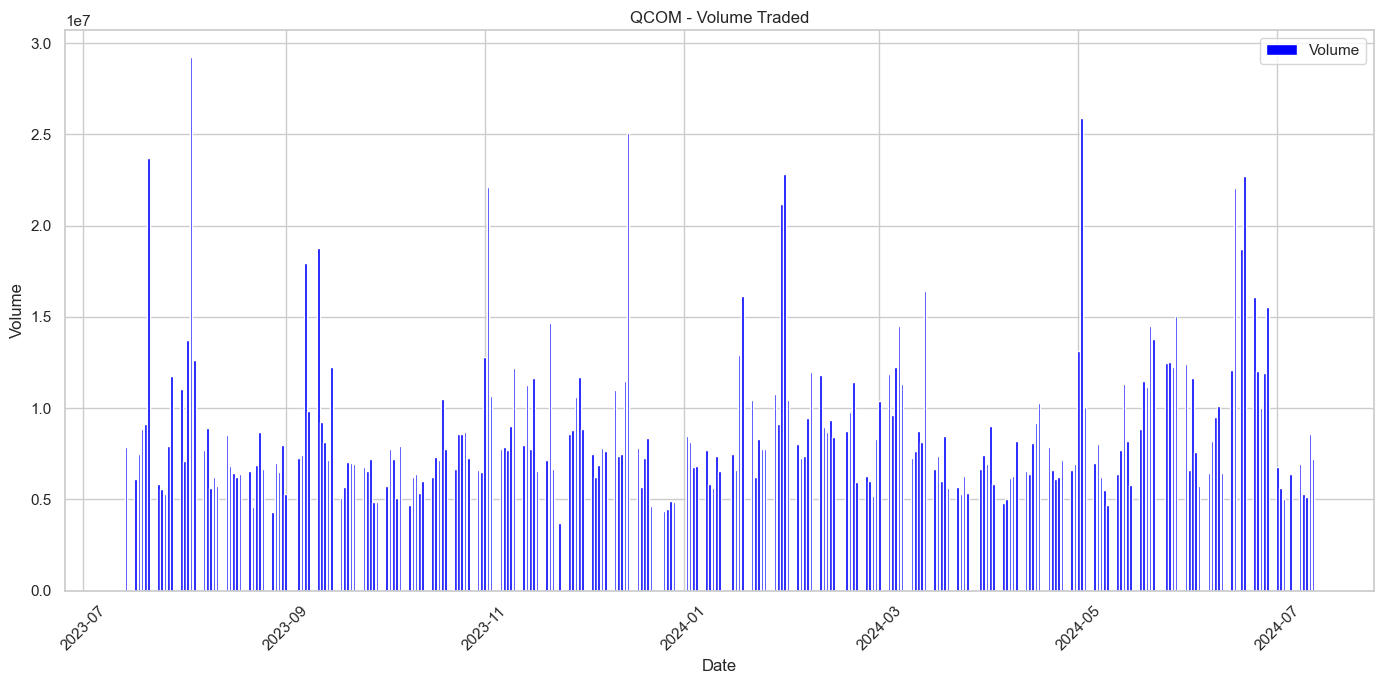

In [4]:
short_window = 50 
long_window = 200

stock_data.set_index('Date', inplace=True)
unique_tickers = stock_data['Tickers'].unique()

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Tickers']==ticker].copy()
    ticker_data['50_MA'] = ticker_data['Adj Close'].rolling(window=short_window).mean()
    ticker_data['200_MA'] = ticker_data['Adj Close'].rolling(window=long_window).mean()
    
    plt.figure(figsize=(14,7))
    plt.plot(ticker_data.index, ticker_data['Adj Close'], label='Adj Close')
    plt.plot(ticker_data.index, ticker_data['50_MA'], label='50_MA')
    plt.plot(ticker_data.index, ticker_data['200_MA'], label='200_MA')
    plt.title(f'{ticker} - Adjust Close and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14,7))
    plt.bar(ticker_data.index, ticker_data['Volume'], label='Volume', color='blue')
    plt.title(f'{ticker} - Volume Traded')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    

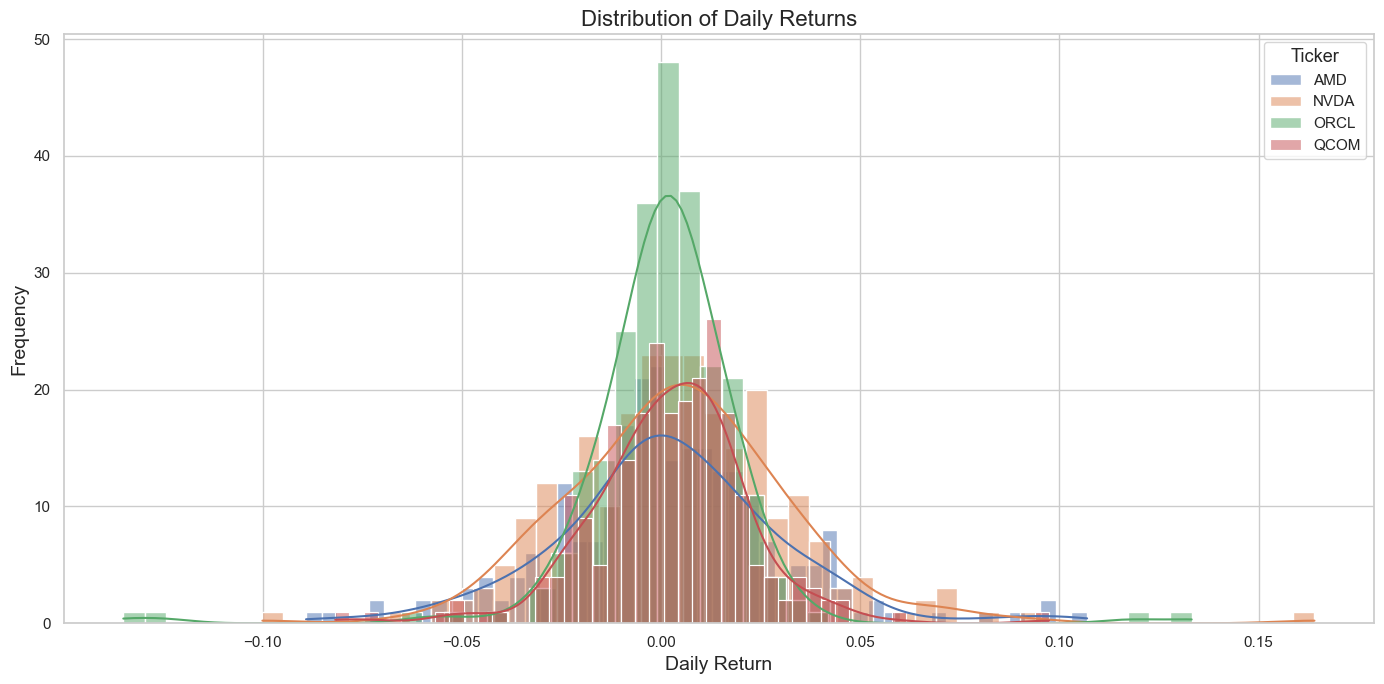

In [9]:
stock_data['Daily Return'] = stock_data.groupby('Tickers')['Adj Close'].pct_change()

# Plot distribution of daily returns
plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Tickers'] == ticker]
    sns.histplot(ticker_data['Daily Return'].dropna(), bins=50, kde=True, label=ticker, alpha=0.5)

plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.tight_layout()
plt.show()

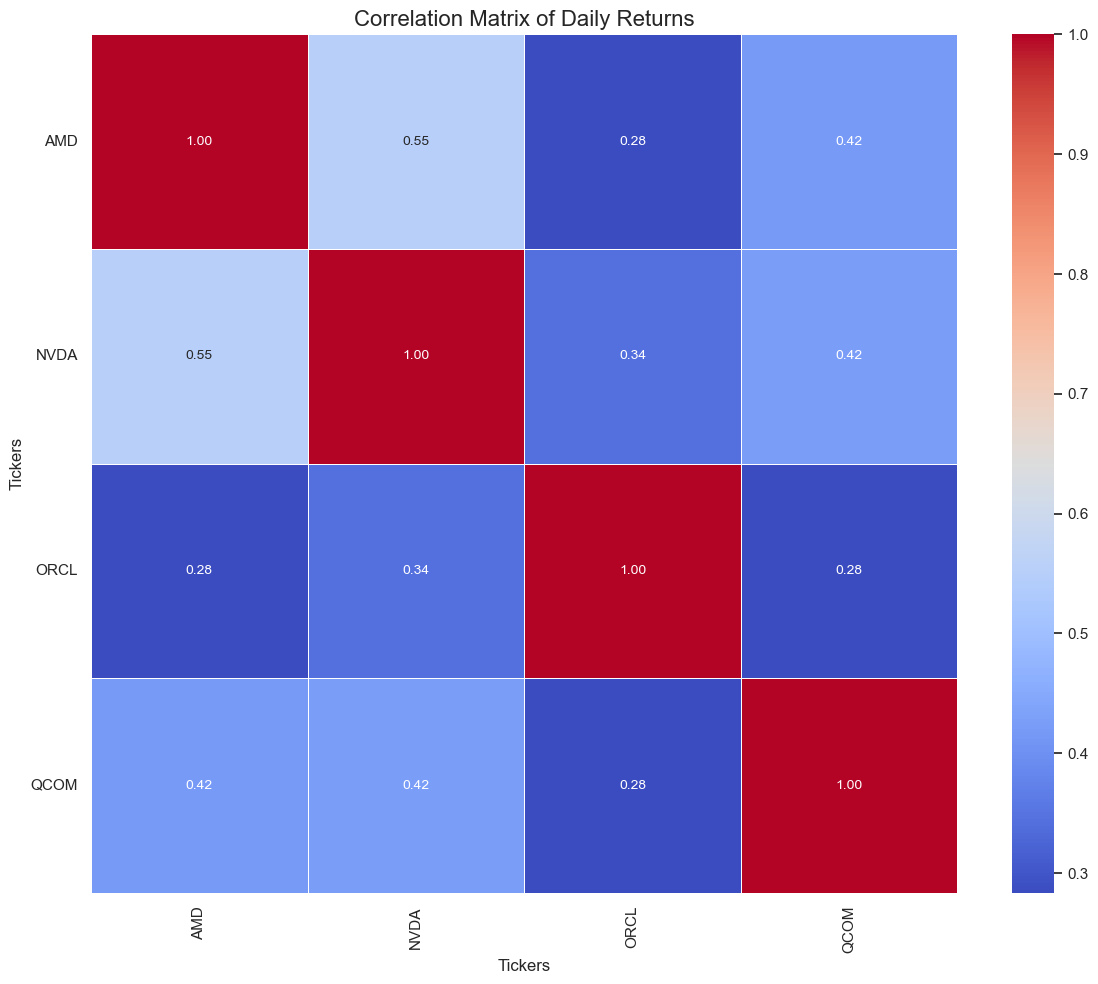

In [11]:
daily_returns = stock_data.pivot_table(index='Date', columns='Tickers', values='Daily Return')
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(12, 10))
sns.set(style='whitegrid')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [12]:
import numpy as np

expected_returns = daily_returns.mean() * 252  # annualize the returns
volatility = daily_returns.std() * np.sqrt(252)  # annualize the volatility

stock_stats = pd.DataFrame({
    'Expected Return': expected_returns,
    'Volatility': volatility
})

stock_stats

,Expected Return,Volatility
Tickers,,
AMD,0.556568,0.457780
NVDA,1.157464,0.455870
ORCL,0.267383,0.340569
QCOM,0.577990,0.313168


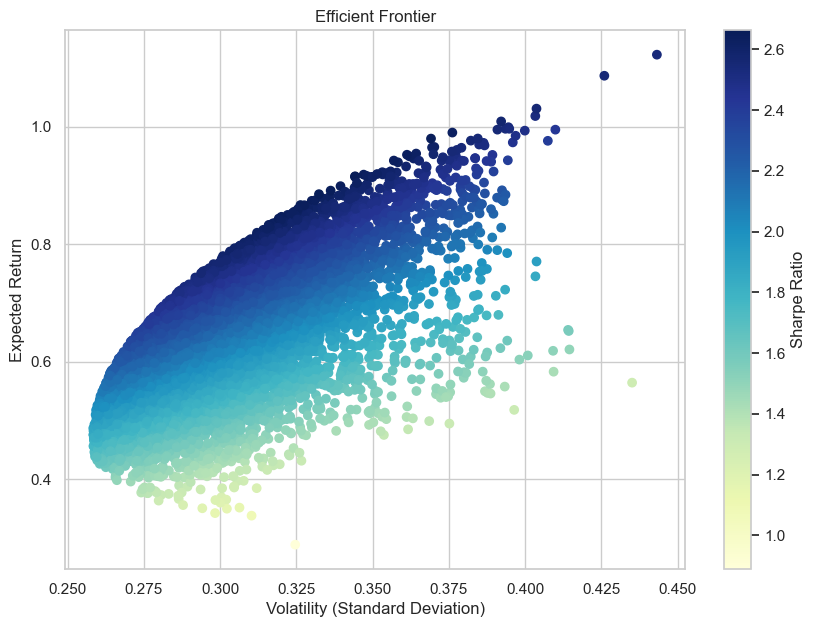

In [13]:
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# number of portfolios to simulate
num_portfolios = 10000

# arrays to store the results
results = np.zeros((3, num_portfolios))

# annualized covariance matrix
cov_matrix = daily_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility  # Sharpe Ratio

plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

In [14]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio

(0.8851657743783233, 0.3324188879023287, 2.6628022852853137)

In [15]:
max_sharpe_weights = np.zeros(len(unique_tickers))

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_tickers,
    'Weight': max_sharpe_weights
})

portfolio_weights_df

,Ticker,Weight
0,AMD,0.071808
1,NVDA,0.028466
2,ORCL,0.126309
3,QCOM,0.773416
